In [480]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [481]:
ameriflux = pd.read_csv('freq_anual/AMF_PE-QFR_FLUXNET_FULLSET_YY_2018-2019_3-5.csv',na_values=-9999) # Dados da AMERIFLUX
modis = pd.read_csv('freq_anual/Npp_500m.csv',header=None)

In [482]:
npp = (ameriflux['NEE_VUT_MEAN'] + ameriflux['RECO_DT_VUT_MEAN']) / 1000 # NPP do Ameriflux gerado pela média do RECO (DURANTE O DIA) + NEE e convertido de gC m−2 y−1 para kgC/m²/year divindo o valor por 1000
npp # NPP calculado                                               # OBS1: RECO_DT = Partitioning NEE using the daytime flux method, Lasslop et al. (2010)
                                                                  # OBS2: _VUT_ = Variable USTAR threshold for each year
                                                                  # OBS3: _MEAN = Average NEE after filtering using multiple USTAR thresholds;

0    2.526743
1    2.518219
dtype: float64

In [483]:
def convert_unit(x):
    return x/10000



modis_data = modis.loc[modis[2].isin(['A2018001','A2019001'])].copy() # Dados de NPP nos anos de 2018 e 2019


modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas


modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 


modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe


modis_data.apply(convert_unit) # Conversão para kgC/m²/year como está disposto no mapa (Adição de um 0 a mais para coincidir com o mapa do site)
# OBS: Os dados de NPP foram retirados de uma área de extensão de 8.5km[17 pixels] x 8.5km[17 pixels],
#      o que equivale a 289 (17x17) dados de NPP na área

,1,2,3,4,5,6,7,8,9,10,...,280,281,282,283,284,285,286,287,288,289
0,,,,,,,,,,,,,,,,,,,,,
A2018001,1.2176,1.1588,3.2762,0.6622,0.6391,0.6549,0.6469,3.2762,3.2762,3.2762,...,1.2052,1.1984,1.1975,1.2014,1.2411,1.2431,1.2027,1.2061,1.1647,1.1426
A2019001,1.0845,1.0508,3.2762,0.5106,0.5571,0.5418,0.5875,3.2762,3.2762,3.2762,...,1.0485,1.0111,1.0692,1.0243,1.0199,1.0259,0.9908,1.0596,1.1172,1.0997


In [484]:
modis_npp_mean = modis_data.apply(lambda x:x/10000).mean(axis=1) # Média de NPP nesses anos
modis_npp_mean

0
A2018001    1.172167
A2019001    1.078046
dtype: float64

In [485]:
modis_npp_mean_values = modis_npp_mean.values # valores do npp do modis
ameriflux_npp_values = npp.values #valores do npp do ameriflux

ameriflux['npp'] = ameriflux_npp_values
ameriflux['npp_modis'] = modis_npp_mean_values

npp_dataframe = {
    'modis_NPP':modis_npp_mean_values,
    'ameriflux_NPP':ameriflux_npp_values
}

npp_dataframe = pd.DataFrame(npp_dataframe) # dataframe com os valores do npp
npp_dataframe

,modis_NPP,ameriflux_NPP
0,1.172167,2.526743
1,1.078046,2.518219


In [486]:
# FUNÇÃO CRIADA PARA CRIAÇÃO DOS GRÁFICOS

def reg_graph (x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    
    sns.set_style('darkgrid')
    
    f, ax = plt.subplots(1,figsize=(8, 5))
    
    sns.scatterplot(x=data[x], y=data[y], data=ameriflux_mensal,size=sct_size)
    
    rng = np.random.default_rng(1234) #seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)   
    fitted_reg = lr.fit(data[[x]],data[[y]])
    
    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_] # Prevenindo erros
        
    r2_score = fitted_reg.score(data[[x]],data[[y]]) # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100) # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada
    
    if reg_from_start:
        x_reg_line = rng.uniform(0, 100 , size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada

    
    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  #eixo x do texto

    
    plt.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
    plt.text(text_coord_x, offset_txt_y - (offset_txt_y*0.3), f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²
    

    ax.set_ylim((0, (data[y].max() + 1))) # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + 1)) # tamanho limite do plot no eixo x
    ax.plot(x_reg_line,y_reg_line[0]) #reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 100, size=1000) # gerando 100 valores aleatórios 
        ax.plot(y_x,y_x, 'k--') # reta y=x
    

    
    plt.title(title) # Título do gráfico
    plt.legend(title=legend_title,loc='upper left').set_visible(legend_visibility) #legenda no canto superior esquerdo
    plt.xlabel(xlabel) #Título do eixo X
    plt.ylabel(ylabel) #Título do eixo y
    plt.tight_layout() #Redimensionar melhor o gráfico
    plt.show() #Mostrar o gráfico
    


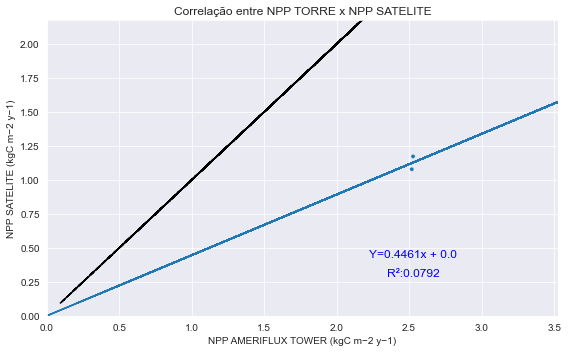

In [487]:
eixo_x = 'ameriflux_NPP'
eixo_y = 'modis_NPP'
data = npp_dataframe
xlabel = "NPP AMERIFLUX TOWER (kgC m−2 y−1)"
ylabel = "NPP SATELITE (kgC m−2 y−1)"
title = "Correlação entre NPP TORRE x NPP SATELITE"

reg_graph(eixo_x,eixo_y,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,fit_intercept=False,ativar_grafico_yx=True,reg_from_start=True, offset_txt_x=0,offset_txt_y=0.45)

In [488]:
#================================================================================================================================================#
    ##  GRAFICOS GERADOS COM BASE NO NPP CALCULADO ##

In [489]:
ameriflux_mensal = pd.read_csv('freq_mensal/AMF_PE-QFR_FLUXNET_FULLSET_MM_2018-2019_3-5.csv',na_values=-9999)
ameriflux_mensal['NPP'] = (ameriflux_mensal['NEE_VUT_MEAN'] + ameriflux_mensal['RECO_DT_VUT_MEAN'])   #OBS: NPP = gC m−2  d−1
npp = ameriflux_mensal['NPP']

Text(0, 0.5, 'NPP')

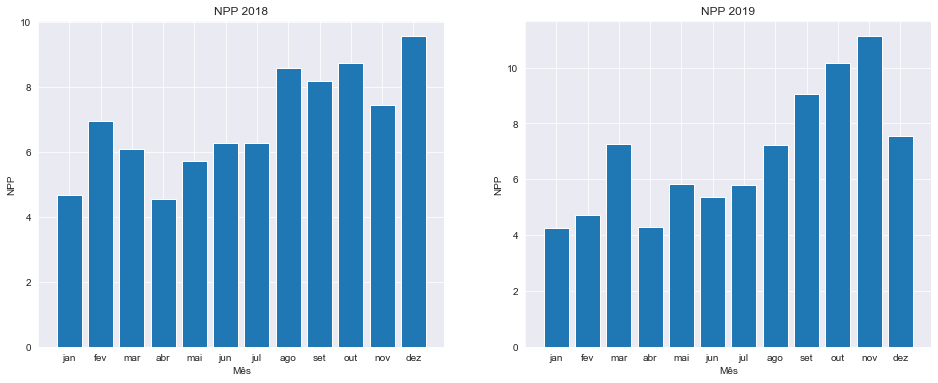

In [490]:
meses_abreviados = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]

df = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[0:12]}) # NPP 2018
df2 = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[12:]}) # NPP 2019


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(df["Meses"], df["NPP"])
axs[0].set_title("NPP 2018")
axs[0].set_xlabel("Mês")
axs[0].set_ylabel("NPP")


axs[1].bar(df2["Meses"], df2["NPP"])
axs[1].set_title("NPP 2019")
axs[1].set_xlabel("Mês")
axs[1].set_ylabel("NPP")

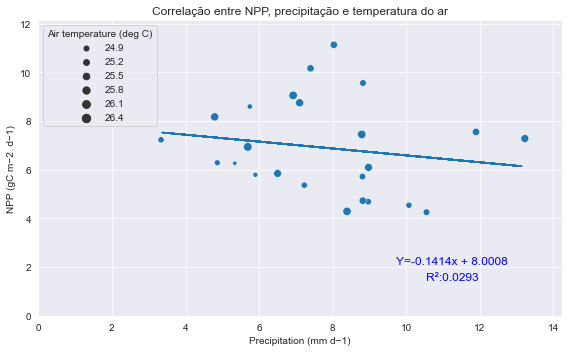

In [491]:
eixo_x = 'P_ERA' #Data filled by using ERA5 downscaling
tamanho = 'TA_ERA' #Air temperature (deg C) Data filled by using ERA5 downscaling
eixo_y = 'NPP'

reg_graph(eixo_x,eixo_y,ameriflux_mensal,sct_size=tamanho,title="Correlação entre NPP, precipitação e temperatura do ar",legend_title="Air temperature (deg C)",xlabel='Precipitation (mm d−1)',ylabel="NPP (gC m−2  d−1)")

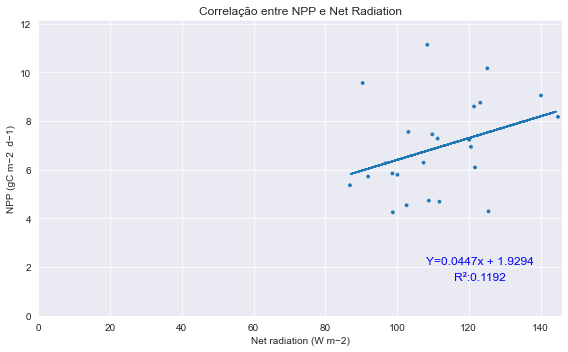

In [492]:
eixo_x = 'NETRAD' #Net Radiation
eixo_y = 'NPP'
dataframe = ameriflux_mensal
title= "Correlação entre NPP e Net Radiation"
xlabel = 'Net radiation (W m−2)'
ylabel = "NPP (gC m−2  d−1)"

reg_graph(eixo_x, eixo_y, data=dataframe, title=title, xlabel=xlabel, ylabel=ylabel, legend_visibility=False)


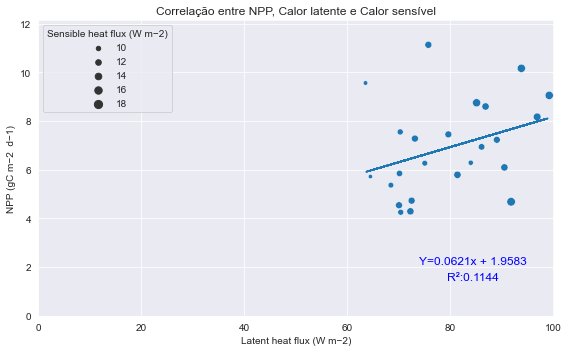

In [493]:
eixo_x = 'LE_F_MDS' #latent_heat / Gap-filled variable  / Marginal Distribution Sampling gap-filling method
eixo_y = 'NPP'
dataframe = ameriflux_mensal
sct_size = 'H_F_MDS' #sensible_heat / Gap-filled variable  / Marginal Distribution Sampling gap-filling method

reg_graph(eixo_x, eixo_y, sct_size=sct_size, data=dataframe, title="Correlação entre NPP, Calor latente e Calor sensível", xlabel="Latent heat flux (W m−2)", ylabel="NPP (gC m−2  d−1)",legend_title="Sensible heat flux (W m−2)")
